In [12]:
import os, sys, cv2, glob

import pandas as pd
import numpy as np
import numpy.linalg as la

import scipy.ndimage
import matplotlib.pyplot as plt
from PIL import Image
from imageio import imread

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import seaborn as sns

import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.transforms import Compose
from torch.autograd import Variable
from efficientnet_pytorch import EfficientNet
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

import lib.ConvNets as ConvNets
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## CNN pipeline Notebook
A python script is located in CNNobjdetector-cv5.py, please follow readme.txt for batch run


In [7]:
torch.manual_seed(700)
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
print('using ', device.type)

using  cpu


In [15]:
from datetime import datetime
def get_time_str():
    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%d-%b-%Y(%H:%M:%S)")
    return timestampStr


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)
        
def prepare_model(name='efn', num_classes=2, learning_rate = 0.005, weight=[], in_channels=1, drop_connect_rate=0.5):
    if name == 'efn':
        model = EfficientNet.from_pretrained('efficientnet-b0',  in_channels=in_channels, 
                                             num_classes=num_classes, drop_connect_rate=drop_connect_rate)
    
    elif name == 'res':

        model = torch.hub.load('pytorch/vision:v0.8.2', 'resnet18', pretrained=True)
        # or any of these variants
        # model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet34', pretrained=True)
        # model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
        # model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet101', pretrained=True)
        # model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet152', pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)   
    elif name =='ConvNet2':
        model = ConvNets.ConvNet2(num_classes)
    else:
        model = ConvNets.ConvNet(num_classes)
    model.eval() 
    
    # Loss and optimizer
    if any(weight):
        criterion = nn.CrossEntropyLoss(weight=weight.to(device))
    else:
        criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return model, criterion, optimizer

def assign_test_val(test_index, train_index):
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    test_df = all_data.iloc[test_index]
    train_df = all_data.iloc[train_index]
    files, labels = np.array(train_df['path']), np.array(train_df['label'])
    val_files, val_labels = np.array(test_df['path']), np.array(test_df['label'])
    return files, labels, val_files, val_labels


def augmentation(npimg, rnum=0):
    r2 = np.random.rand(3)
    if rnum == 0:
        return npimg
    if rnum == 1:
        return cv2.rotate(npimg, cv2.ROTATE_90_CLOCKWISE)
    if rnum == 2:
        return cv2.rotate(npimg, cv2.ROTATE_90_COUNTERCLOCKWISE)
    if rnum == 3:
        return cv2.rotate(npimg, cv2.ROTATE_180)
    if rnum == 4:
        return cv2.flip(npimg, 0)
    if rnum == 5:
        return cv2.flip(npimg, 1)
    if rnum == 6:
        return cv2.flip(npimg, -1)
#     if rnum == 7:
#         return cv2.flip(cv2.rotate(npimg, cv2.ROTATE_90_CLOCKWISE),0)
#     if rnum == 8:
#         return cv2.flip(cv2.rotate(npimg, cv2.ROTATE_90_COUNTERCLOCKWISE),0)
#     if rnum == 9:
#         return cv2.flip(cv2.rotate(npimg, cv2.ROTATE_180),0
    
    

In [3]:
all_data = pd.read_csv('/home/wujiayi/IPF/Data/CNN/tr_data_1206.csv', index_col = 0)
all_data.head()

,type,patch,patient Id,slice,path,label,test
0,emphysema,1000,1,7,emphysema_patch1000_patient-1_7.tif,0,False
1,emphysema,1001,1,7,emphysema_patch1001_patient-1_7.tif,0,True
2,emphysema,1002,1,7,emphysema_patch1002_patient-1_7.tif,0,False
3,emphysema,1003,1,7,emphysema_patch1003_patient-1_7.tif,0,False
4,emphysema,1004,1,7,emphysema_patch1004_patient-1_7.tif,0,False


In [4]:
all_data.groupby('type').count()

,patch,patient Id,slice,path,label,test
type,,,,,,
emphysema,1177,1177,770,1177,1177,1177
fibrosis,3039,3039,77,3039,3039,3039
ground,2226,2226,2226,2226,2226,2226
healthy,5530,5530,2519,5530,5530,5530
micronodules,6821,6821,833,6821,6821,6821


In [5]:
dic = np.load('/home/wujiayi/IPF/Data/CNN/ht-img.npy', allow_pickle = True).item()

In [8]:
tot = sum(all_data['type'].value_counts())
weight = [1, 2, 1, 2, 0.8]#tot/(all_data[['label']]).value_counts().sort_index()/5
# weight = np.sum(weight)
print('weight each index like below')
print(weight)
weight = torch.tensor(weight, dtype=torch.float32)
print('convert weight into tensor:', weight)

weight each index like below
[1, 2, 1, 2, 0.8]
convert weight into tensor: tensor([1.0000, 2.0000, 1.0000, 2.0000, 0.8000])


In [53]:
def training(model, files, labels, val_files, val_labels, 
             j=0, num_epochs = 5,total_step = 5000, batch_size = 64, checkpoint_name = 'conv_network_model_ConvNet_aug'):
    loss_list = []
    acc_list = []
    va = []
    for epoch in range(num_epochs): 
        for i in range(total_step):
            # Run the forward pass
            batch_ind = np.random.randint(len(labels), size = batch_size)
            b_imgs = torch.from_numpy(np.array([augmentation(dic[files[ind]], np.random.randint(7)) for ind in batch_ind])).unsqueeze(1).float().to(device)
            b_labels = torch.from_numpy(labels[batch_ind]).to(device)

            outputs = model(b_imgs)

            loss = criterion(outputs, b_labels)
            loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = b_labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == b_labels).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % 1000 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 100))


        b_imgs = torch.from_numpy(np.array([dic[i] for i in val_files])).unsqueeze(1).float().to(device)
        outputs = model(b_imgs)

        b_labels = torch.from_numpy(val_labels).to(device)                       
        total = b_labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == b_labels).sum().item()
        print('val accuracy', correct/total)
        va += [correct/total]  
        timestampStr = get_time_str()
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': correct/total,
            }, 'checkpoint/%s_%04d_b0'%(timestampStr,epoch))
    
    y_pred_labels = predicted.cpu().numpy() 
    y_true_labels = val_labels
    confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels, normalize= 'true')
    
    name = "checkpoint/"+checkpoint_name+"_cv%04d"%j
    if os.path.exists(name):
        print('file exist, please rename')
    else:
        torch.save(model, name)
        print('saved as ', name)
    print(np.max(acc_list))  
    if np.max(acc_list)<0.8:
        print('rerun')
        torch.manual_seed(np.random.randint(100000))
        weights_init(model)
        training(model, files, labels, val_files, val_labels, 
             j, num_epochs,total_step, batch_size, checkpoint_name +'rerun')
    else:   
        return loss_list, acc_list, va, confusion_matrix


In [13]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
X = all_data['path']
kf.get_n_splits(X)

5

In [61]:
cv5 = []
j =0
cms = []
for train_index, test_index in kf.split(X):   
    j+=1
    print('cv: ', j)
    
    files, labels, val_files, val_labels = assign_test_val(test_index, train_index)
    model, criterion, optimizer = prepare_model(name='efn', num_classes=5, learning_rate = 0.0005, weight = weight)
    model.to(device)
    
    loss_list, acc_list, va, confusion_matrix = training(model, files, labels, val_files, val_labels, j=j, num_epochs = 5,
                                       total_step = 3000, batch_size = 64, checkpoint_name = 'b0_aug')
    
    cv5 += [va[-1]]
    cms += [confusion_matrix]

        

cv:  1
Loaded pretrained weights for efficientnet-b0
Epoch [1/5], Step [1000/3000], Loss: 0.5844, Accuracy: 73.44%
Epoch [1/5], Step [2000/3000], Loss: 0.6149, Accuracy: 73.44%
Epoch [1/5], Step [3000/3000], Loss: 0.3564, Accuracy: 82.81%
val accuracy 0.819366852886406
Epoch [2/5], Step [1000/3000], Loss: 0.3086, Accuracy: 82.81%
Epoch [2/5], Step [2000/3000], Loss: 0.2786, Accuracy: 85.94%
Epoch [2/5], Step [3000/3000], Loss: 0.4075, Accuracy: 81.25%
val accuracy 0.8475658419792498
Epoch [3/5], Step [1000/3000], Loss: 0.2165, Accuracy: 92.19%
Epoch [3/5], Step [2000/3000], Loss: 0.2370, Accuracy: 87.50%
Epoch [3/5], Step [3000/3000], Loss: 0.0790, Accuracy: 98.44%
val accuracy 0.8598031391327481
Epoch [4/5], Step [1000/3000], Loss: 0.2730, Accuracy: 89.06%
Epoch [4/5], Step [2000/3000], Loss: 0.0894, Accuracy: 95.31%
Epoch [4/5], Step [3000/3000], Loss: 0.1296, Accuracy: 92.19%
val accuracy 0.88560787443469
Epoch [5/5], Step [1000/3000], Loss: 0.1693, Accuracy: 95.31%
Epoch [5/5], Ste

In [62]:
cv5

[0.8760308592710827,
 0.8643256185155627,
 0.8832136206437883,
 0.8932943054816391,
 0.8783927621075039]

In [68]:
np.mean(cv5), np.std(cv5)

(0.8790514332039153, 0.00945082586588969)

Text(0.5, 0, 'Epoch')

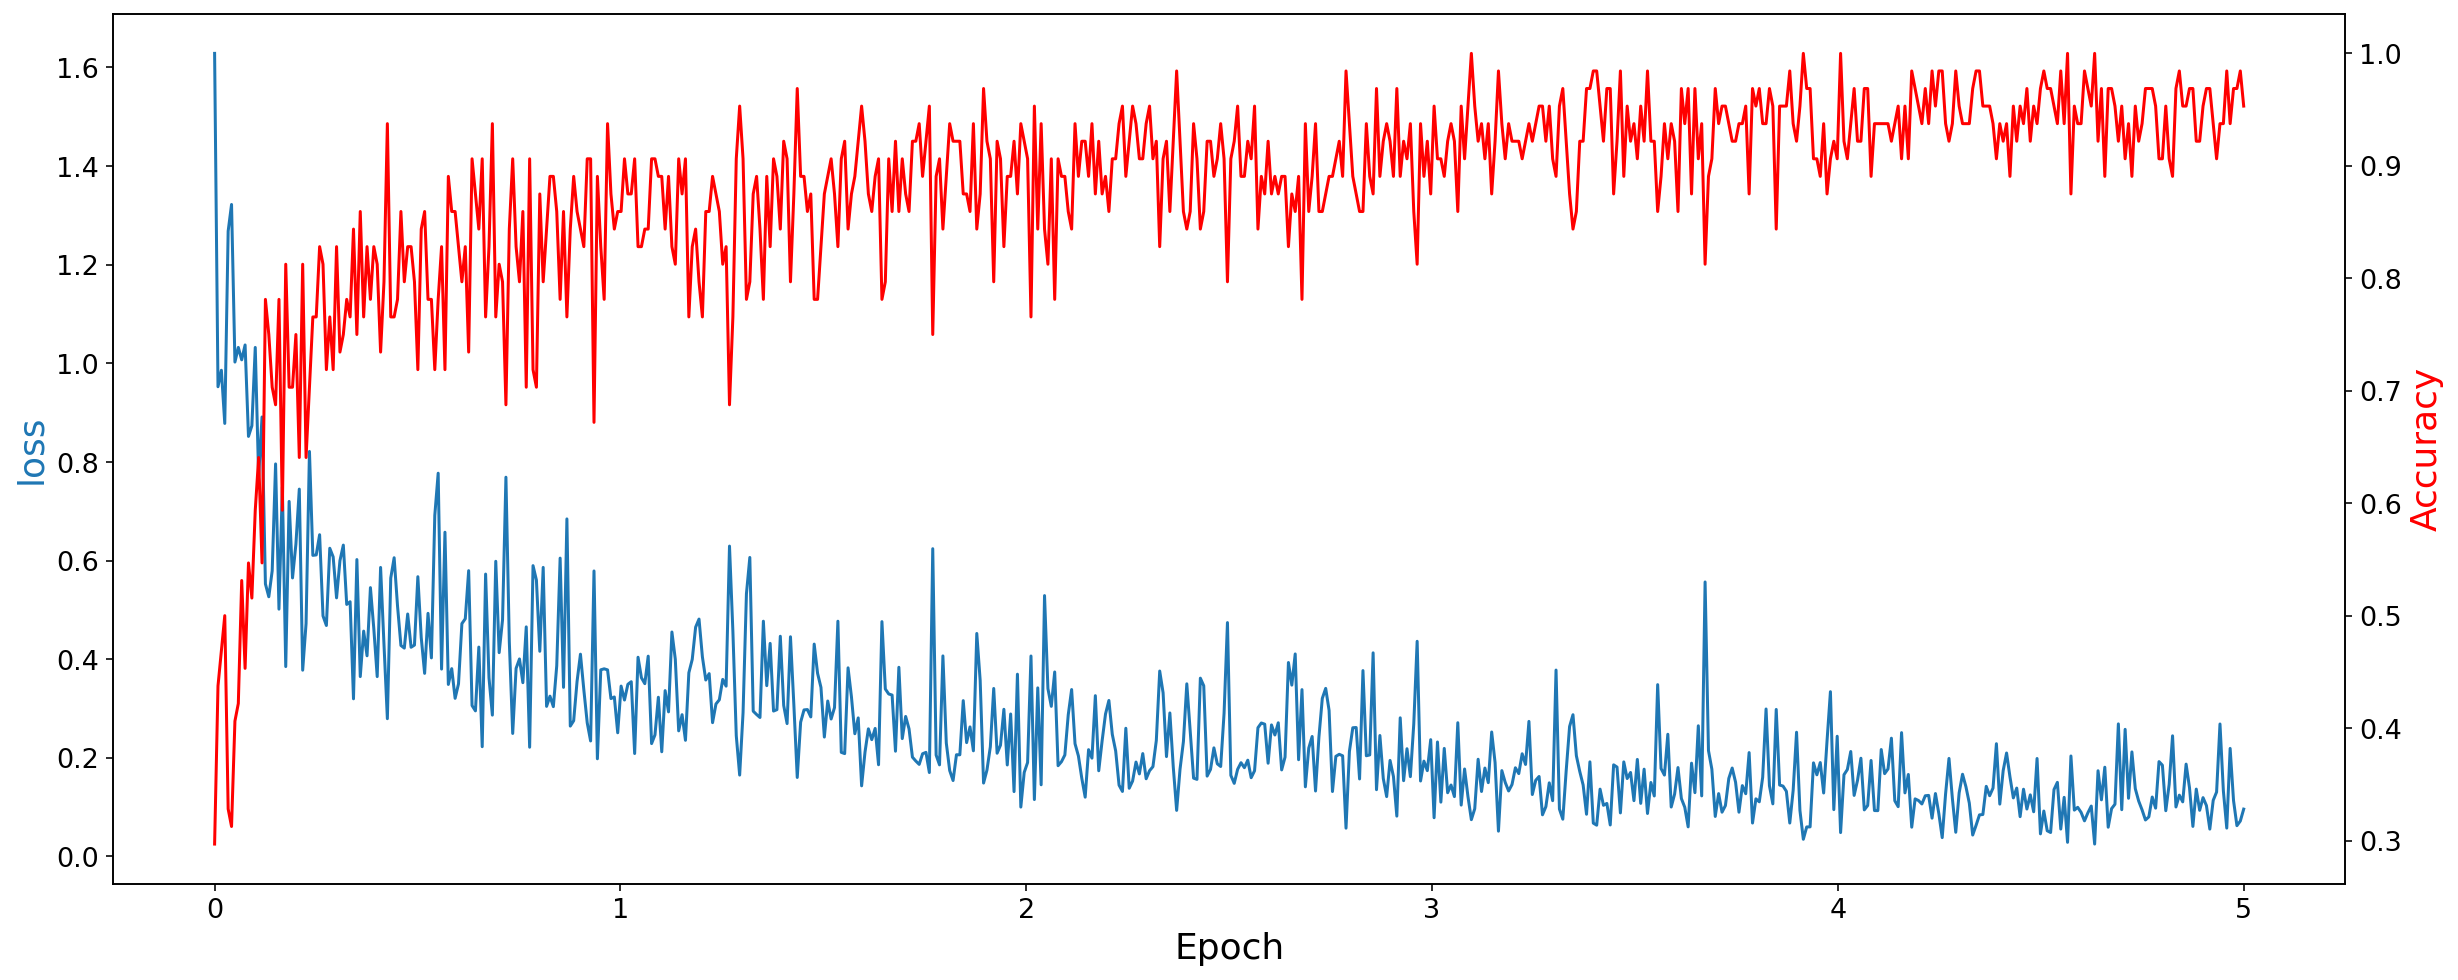

In [64]:
num_epochs = 5
fig, ax1 = plt.subplots()
y=loss_list[::25]
ax1.plot(np.linspace(0, num_epochs, len(y)), y)
ax1.set_ylabel('loss', color='tab:blue', fontsize = 18) 

ax2 = ax1.twinx()
ax2.plot(np.linspace(0, num_epochs, len(y)), acc_list[::25], 'r')



plt.xlabel('Epoch')

ax2.set_ylabel('Accuracy', color='r', fontsize = 18) 
ax1.set_xlabel('Epoch', fontsize = 18)

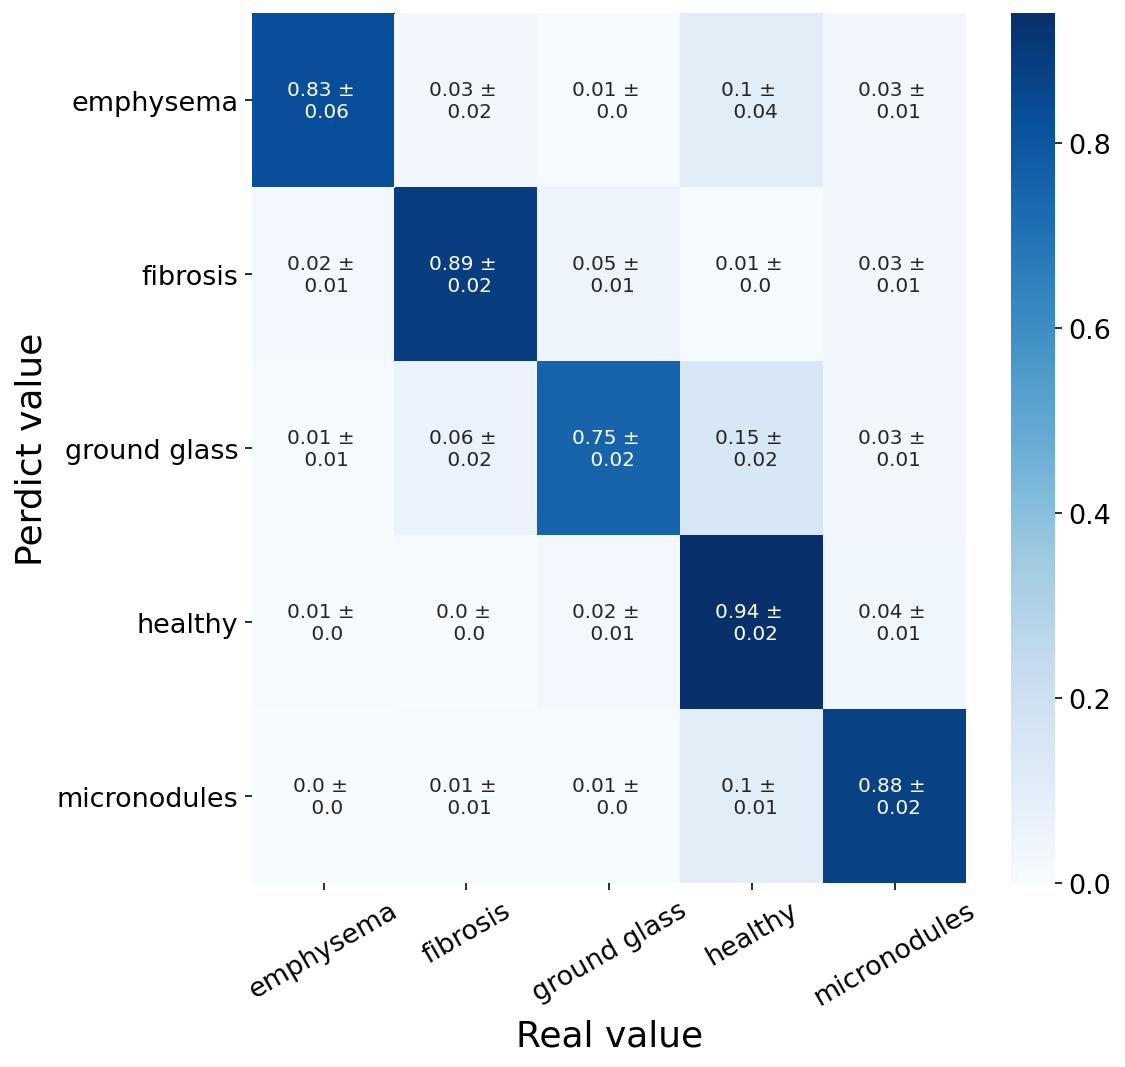

In [67]:

import seaborn as sns
size=18
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 2}
plt.rcParams.update(params)
z = np.round(np.mean(cms, axis = 0),2)
zstd = np.round(np.std(cms, axis = 0),2).flatten()
plt.figure(figsize=(8,8))
labels = [f'{v1} ± \n {v2}' for v1, v2 in
          zip(z.flatten(), zstd)]
labels = np.asarray(labels).reshape(5,5)
ax = sns.heatmap(z, annot=labels,  fmt='',cmap='Blues')
# xlabels = [item.get_text() for item in ax.get_xticklabels()]
xlabels = ['emphysema', 'fibrosis', 'ground glass', 'healthy', 'micronodules']
ax.set_xticklabels(xlabels, rotation =30)
ax.set_yticklabels(xlabels, rotation = 360)
plt.xlabel('Real value')
plt.ylabel('Perdict value')
plt.show()

In [ ]:
# torch.save(model.state_dict(), "./conv_network_dic")
name = "./conv_network_model_b0_06022021_aug_5"
if os.path.exists(name):
    print('file exist, please rename')
else:
    torch.save(model, name)
    print('saved as ', name)

